# PreProcessing


در این پروژه هدف ما خوشه‌بندی املاک موجود در مجموعه داده‌ها برای توسعه سیستم توصیه‌گر ملک است. خوشه‌ها باید بر اساس ویژگی‌های معنادار انتخاب شده باشند تا بتوانند سلیقه و نیاز کاربر را منعکس کنند.

به همین منظور، مراحل پیش‌پردازش داده‌ها انجام شد تا کیفیت داده‌ها بهبود یافته و برای الگوریتم‌های
 KMeans و DBSCAN
  آماده شود.

Import Libraries :

In [1]:
import pandas as pd
import numpy as np
import jdatetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import geopandas as gpd
import utm
from shapely.geometry import Point
import geodatasets

Read Datasets :

In [ ]:
# Data Loading
df = pd.read_csv('Data/Divar.csv')


Splitting Dataset :

تفکیک داده‌ها بر اساس نوع معامله

ستون cat2_slug برای تعیین نوع معامله استفاده شد و به دو دسته تبدیل شد:

Sell: شامل معاملات فروش (مسکونی و تجاری)

Rent: شامل معاملات اجاره (مسکونی، تجاری و موقت)

دلیل: خوشه‌بندی داده‌های فروش و اجاره باید جداگانه انجام شود تا معنادار باشد، زیرا ویژگی‌ها و مقیاس‌ها متفاوت هستند.

In [3]:
# تقسیم دیتا به دو بخش sell , rent
deal_type_map = {
    'residential-sell' : 'sell',
    'commercial-sell' : 'sell',
    'residential-rent' : 'rent',
    'commercial-rent' : 'rent',
    'temporary-rent' : 'rent',
    'real-estate-services' : 'sell',
    }
# ساخت ستون جدید در دیتافریم
df['deal_type'] = df['cat2_slug'].map(deal_type_map)
df_sell = df[df['deal_type'] == 'sell'].copy()
df_rent = df[df['deal_type'] == 'rent'].copy()

پردازش تاریخ ایجاد و سال ساخت

ستون created_at_month به فرمت تاریخ جلالی تبدیل شد تا سال ساخت ساختمان محاسبه شود (created_year_jalali).

ستون construction_year:

داده‌های خالی با 0 جایگزین شد.

مقادیر متنی مانند "قبل از ۱۳۷۰" به 1369 تبدیل شد.

اعداد فارسی به انگلیسی تبدیل شدند و سپس به عدد تبدیل شدند.

دلیل: سال ساخت برای محاسبه سن ساختمان ضروری است و داده‌های غیر عددی یا خالی باید اصلاح شوند.

In [4]:
# بررسی ستون تاریخ
df['created_at_month'] = pd.to_datetime(df['created_at_month'], errors='coerce')
df['created_date'] = df['created_at_month'].apply(lambda x: jdatetime.date.fromgregorian(date=x))
df['created_year_jalali'] = df['created_date'].apply(lambda x: x.year)

# بررسی ستون construction_year
def persian_to_english_number(text):
    persian_digits = '۰۱۲۳۴۵۶۷۸۹'
    english_digits = '0123456789'
    trans_table = str.maketrans(persian_digits, english_digits)
    return str(text).translate(trans_table)

# پاک کردن ردیف های فروش آپارتمان و خانه ویلایی بدون سال ساخت
df = df[~((df['deal_type'] == 'sell') &
          (df['cat3_slug'].isin(['apartment-sell', 'house-villa-sell']) | df['cat3_slug'].isna()))]

# جایگزاری عبارت بدون سال ساخت به جای داده های بدون معنی برای داشتن تاریخ
df['construction_year'] = df['construction_year'].fillna(0)

df['construction_year'] = df['construction_year'].astype(str).replace({'قبل از ۱۳۷۰': '1369'})
df['construction_year'] = df['construction_year'].apply(persian_to_english_number)
df['construction_year'] = pd.to_numeric(df['construction_year'], errors='coerce')


داده‌های building_size که خالی بودند با میانگین یا میانه جایگزین شدند.

داده‌های کمتر از 30 متر مربع حذف شدند.

دلیل: داده‌های بسیار کوچک ممکن است ناشی از خطا باشند و روی خوشه‌بندی تأثیر نامطلوب داشته باشند.

In [5]:
median_size = df['building_size'].median()
df['building_size'] = df['building_size'].fillna(median_size)
print(df['building_size'].isna().sum())

# Analysing Missing building size
df = df[df['building_size'] >= 30]

0


پردازش اجاره و رهن

ستون‌های rent_value و credit_value برای معاملات اجاره بررسی و اصلاح شدند.

داده‌های ناقص یا کمتر از یک میلیون تومان حذف یا محاسبه شدند (بر اساس نرخ تبدیل conversion_rate = 0.4).

اجاره‌ها به مقدار رهن بر متر مربع تبدیل شدند (credit_per_m2).

دلیل: داشتن ویژگی یکنواخت و قابل مقایسه برای خوشه‌بندی ضروری است.

In [6]:
# نرخ تبدیل اجاره به رهن
conversion_rate = 0.4
rent_items = df['deal_type'] == 'rent'
rent_type_full_credit = df['rent_type'] == 'full_credit'
rent_type_rent_credit = df['rent_type'] == 'rent_credit'
rent_type_na = df['rent_type'].isna()

# جایگزاری خالی ها با داده درست
rent_credit = rent_items & rent_type_na & (df['rent_value'] < df['credit_value'])
full_credit = rent_items & rent_type_na & (df['rent_value'] == df['credit_value'])
zero_credit = rent_items & rent_type_na & (df['credit_value'] <= 1000000)
df.loc[full_credit, 'rent_type'] = 'full_credit'
df.loc[rent_credit, 'rent_type'] = 'rent_credit'
df.loc[zero_credit, 'rent_type'] = 'rent_credit'

# حذف ردیف هایی که نوع اجاره و اجاره و رهن خالی باشد
null_drop = rent_items & df['rent_type'].isna() & df['rent_value'].isna() & df['credit_value'].isna()
df = df[~null_drop]

# #حذف ردیف های نوع اجاره و رهن خالیه
null_credit_drop = rent_items & df['rent_type'].isna() & df['credit_value'].isna() & df['rent_value'].notna()
df = df.loc[~null_credit_drop]

# # حذف ردیف های رهن کامل با شرط رهن که خالی هستند و اجاره ندارند
drop_null_full_credit = rent_items & rent_type_full_credit & (df['credit_value'].isna())
df = df.loc[~drop_null_full_credit]

# حذف داده های خالی رهن
null_credit = rent_items & df['rent_value'].isna() & df['credit_value'].isna()
df = df.loc[~null_credit]

# حذف داده های کمتر از 1000000
less_items = rent_items & (df['credit_value'] <= 1000000) & (df['rent_value'] <= 1000000)
df = df.loc[~less_items]

drop_less_items = rent_items & (df['credit_value'] <= 1000000) & (df['rent_value'].isna())
df = df.loc[~drop_less_items]

adjust_less_items = rent_items & (df['credit_value'] <= 1000000)
df.loc[adjust_less_items, 'credit_value'] = (df.loc[adjust_less_items, 'rent_value'] * 12  / conversion_rate)

adjust_nan_items = rent_items & (df['credit_value'].isna())
df.loc[adjust_nan_items, 'credit_value'] = (df.loc[adjust_nan_items, 'rent_value'] * 12  / conversion_rate)

# تبدیل اجاره به رهن برای داده های قابل تبدیل
rent_to_credit = rent_items & rent_type_rent_credit & df['rent_value'].notna()
df.loc[rent_to_credit, 'credit_value'] = (df.loc[rent_to_credit, 'rent_value'] * 12  / conversion_rate) + df.loc[rent_to_credit, 'credit_value']

# پاک کردن رهن صفر
zero_credit_value = rent_items & (df['credit_value'] == 0)
df = df.loc[~zero_credit_value]

# تبدیل داده ها به متر مربع
df.loc[rent_items , 'credit_per_m2'] = df.loc[rent_items , 'credit_value'] / df.loc[rent_items , 'building_size']

Price Value

پردازش فروش

داده‌های بدون قیمت یا کمتر از 5 میلیون تومان حذف شدند.

قیمت به قیمت بر متر مربع تبدیل شد (price_per_m2).

دلیل: همانند اجاره، برای خوشه‌بندی معنادار نیاز به ویژگی استاندارد و بدون داده‌های پرت داریم.

In [7]:
sell_items = df['deal_type'] == 'sell'

# حدف داده های صفر
zero_price = sell_items & (df['price_value'].isna())
df = df.loc[~zero_price]

# حدف داده های کمتر از 5 میلیون
less_price = sell_items & (df['price_value'] <= 5000000)
df = df.loc[~less_price]

# تبدیل داده ها به متر مربع
df.loc[sell_items , 'price_per_m2'] = df.loc[sell_items , 'price_value'] / df.loc[sell_items , 'building_size']

تکمیل مختصات جغرافیایی

مختصات Latitude و Longitude بررسی و داده‌های خالی با مختصات مرکز شهر جایگزین شدند (استفاده از فایل shapefile استان‌ها).

دلیل: داده‌های جغرافیایی خالی نمی‌توانند در خوشه‌بندی مبتنی بر مکان استفاده شوند.

In [8]:
world = gpd.read_file("Geometry Data/ne_10m_admin_0_countries.shp")
iran = world[world['ADMIN'] == 'Iran']

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["location_longitude"], df["location_latitude"]),
    crs="EPSG:4326"
)
city_coords = gpd.read_file("Geometry Data/Province/province.shp")
# print(city_coords.columns)

city_coords['lat'] = city_coords.geometry.centroid.y
city_coords['lon'] = city_coords.geometry.centroid.x

city_coords = city_coords.rename(columns={'ostn_name': 'city_slug'})
city_coords = city_coords[['city_slug', 'lat', 'lon']]

gdf_points = gdf_points.merge(city_coords, on='city_slug', how='left', suffixes=('', '_city'))

gdf_points['location_latitude'] = gdf_points['location_latitude'].fillna(gdf_points['lat'])
gdf_points['location_longitude'] = gdf_points['location_longitude'].fillna(gdf_points['lon'])

gdf_points = gdf_points.drop(columns=['lat','lon'])

gdf_points['geometry'] = gpd.points_from_xy(gdf_points['location_longitude'], gdf_points['location_latitude'])
gdf_points['in_iran'] = gdf_points.within(iran.geometry.iloc[0])
df_clean = gdf_points[gdf_points['in_iran']].copy()
df = df_clean.copy()


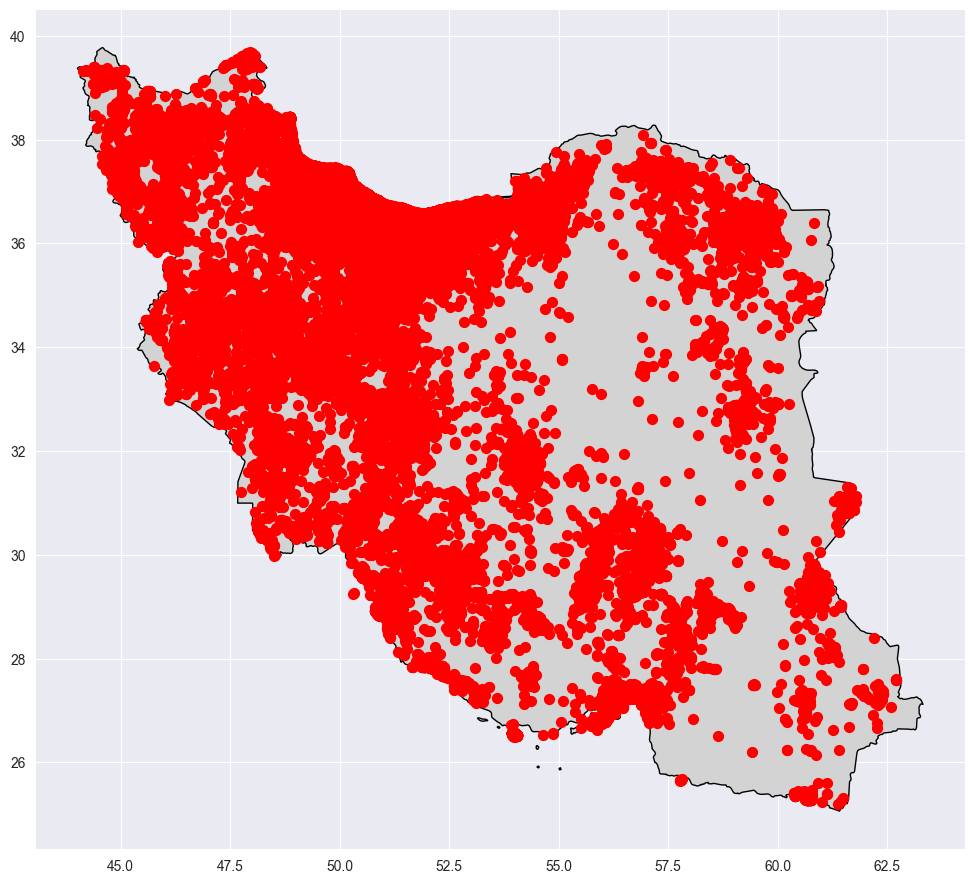

In [9]:
geometry = [Point(xy) for xy in zip(df_clean["location_longitude"], df_clean["location_latitude"])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 12))
iran.plot(ax=ax, color="lightgray", edgecolor="black")
gdf.plot(ax=ax, color="red", markersize=50)
plt.show()

بررسی ستون city_slug و کدگذاری

ستون city_slug با دسته‌بندی شهرها (شهر کوچک / کلان‌شهر) جایگزین شد.

سپس به مقادیر عددی تبدیل شد (0 و 1) برای استفاده در الگوریتم‌های خوشه‌بندی.

دلیل: ویژگی طبقه‌ای برای الگوریتم‌های عددی باید به عدد تبدیل شود.

In [10]:
# بررسی ستون city_slug
#پر کردن داده های null ستون شهر
df_city = pd.read_csv("Data/iran_city_classification.csv")
print("شهر های گم شده جدید: ", df['city_slug'].isna().sum())
print(df['city_slug'].value_counts())
# Label encoding city slug
city_category_map = dict(zip(df_city['نام شهر'], df_city['دسته‌بندی']))
df['city_type'] = df['city_slug'].map(city_category_map)
df['city_type'] = df['city_type'].fillna('شهر کوچک')
df['city_type'] = df['city_type'].map({'شهر کوچک': 0, 'کلان‌شهر': 1})

print(df['city_type'].value_counts())
print(df['city_type'].isna().sum())

شهر های گم شده جدید:  0
city_slug
tehran         67410
mashhad        17150
karaj          16192
isfahan        11348
shiraz         10070
               ...  
boluk              3
inche-borun        3
dozin              3
goli-dagh          1
tatar-olya         1
Name: count, Length: 419, dtype: int64
city_type
0    160083
1    142958
Name: count, dtype: int64
0


تبدیل مختصات به UTM

مختصات Latitude/Longitude به UTM تبدیل شدند (utm_easting و utm_northing).

دلیل: برای مقایسه فاصله‌ها در الگوریتم KMeans و DBSCAN بهتر است که مختصات به واحد متر تبدیل شوند تا مقیاس یکنواخت داشته باشند.

In [11]:
valid_items = (df['location_latitude'] >= -80) & (df['location_latitude'] <= 84) & \
             (df['location_longitude'] >= -180) & (df['location_longitude'] <= 180)

utm_coords = df.loc[valid_items].apply(
    lambda row: utm.from_latlon(row['location_latitude'], row['location_longitude'])[:2], axis=1
)
utm_coords = np.array(utm_coords.tolist())
df.loc[valid_items, 'utm_easting'] = utm_coords[:, 0]
df.loc[valid_items, 'utm_northing'] = utm_coords[:, 1]

df['utm_combined'] = df['utm_easting'] * 1e6 + df['utm_northing']

print(df[['location_latitude', 'location_longitude', 'utm_easting', 'utm_northing']].head())


    location_latitude  location_longitude    utm_easting  utm_northing
0           35.703865           51.373459  533784.424394  3.951168e+06
4           35.733952           51.380608  534418.186786  3.954507e+06
5           31.265947           48.568604  268498.545015  3.461627e+06
7           35.890186           51.280197  525288.498344  3.971805e+06
10          34.333435           58.655319  652273.042591  3.800368e+06


پردازش تعداد اتاق

داده‌های متنی (بدون اتاق, یک, دو و …) به عدد تبدیل شدند.

داده‌های خالی با 0 جایگزین شدند.

دلیل: تعداد اتاق یک ویژگی عددی مهم برای خوشه‌بندی است و باید استاندارد شود.

In [12]:
# بررسی ستون rooms_count
print(df['rooms_count'].value_counts())
print(df['rooms_count'].isna().sum())
mapping = {'بدون اتاق':0, 'یک':1, 'دو':2, 'سه':3, 'چهار':4, 'پنج یا بیشتر':5}
df['rooms_count'] = df['rooms_count'].map(mapping)
df['rooms_count'] = df['rooms_count'].fillna(0)

rooms_count
دو              104991
یک               59840
سه               33208
بدون اتاق        26565
چهار              4223
پنج یا بیشتر      3587
Name: count, dtype: int64
70627


محاسبه سن ساختمان

building_age = created_year_jalali - construction_year

ساختمان‌های با سن منفی یا بیشتر از 40 سال حذف شدند.

دلیل: سن‌های نامعقول یا منفی می‌توانند کیفیت خوشه‌بندی را کاهش دهند.

In [13]:
df['building_age'] = df['created_year_jalali'] - df['construction_year']
df = df[(df['building_age'] >= 0) & (df['building_age'] <= 40)].copy()


. آماده‌سازی داده‌ها برای خوشه‌بندی

دو مجموعه داده جداگانه برای خوشه‌بندی ایجاد شد:

Sell: شامل ویژگی‌ها rooms_count, utm_easting, utm_northing, city_type, building_age, price_per_m2

Rent: شامل ویژگی‌ها rooms_count, utm_easting, utm_northing, city_type, building_age, credit_per_m2

داده‌های ناقص حذف شدند و فایل‌های CSV جداگانه ایجاد شد (cleaned_sell_data.csv و cleaned_rent_data.csv).

دلیل: الگوریتم‌های خوشه‌بندی نیاز به داده‌های کامل دارند و ویژگی‌های انتخاب شده برای معنا داشتن خوشه‌ها ضروری هستند.

In [14]:
rent_items = df['deal_type'] == 'rent'
valid_size = df['building_size'] > 0

cluster_rent_data = ['rooms_count', 'utm_easting', 'utm_northing', 'city_type', 'building_age','credit_per_m2',
                     'location_latitude', 'location_longitude']
df_clean_rent = df[cluster_rent_data].copy()

df_clean_rent.to_csv("Data/cleaned_rent_data.csv", index=False)
df_clean_rent = pd.read_csv("Data/cleaned_rent_data.csv")

df_clean_rent = df_clean_rent[df_clean_rent['credit_per_m2'].notna()].copy()
df_clean_rent.to_csv('Data/cleaned_rent_data.csv', index=False)

In [15]:
sell_items = df['deal_type'] == 'sell'
df = df[~(sell_items & df['price_per_m2'].isna())].copy()

cluster_sell_data = ['rooms_count', 'utm_easting', 'utm_northing', 'city_type', 'building_age','price_per_m2',
                     'location_latitude', 'location_longitude']
df_clean_sell = df[cluster_sell_data].copy()

df_clean_sell.to_csv("Data/cleaned_sell_data.csv", index=False)
df_clean_sell = pd.read_csv("Data/cleaned_sell_data.csv")

df_clean_sell = df_clean_sell[df_clean_sell['price_per_m2'].notna()].copy()
df_clean_sell.to_csv('Data/cleaned_sell_data.csv', index=False)

پس از این مراحل، داده‌ها:

بدون داده‌های پرت و ناقص

دارای ویژگی‌های استاندارد شده

جداگانه برای فروش و اجاره

آماده برای KMeans و DBSCAN

این پیش‌پردازش باعث شد که خوشه‌بندی‌ها معنادار، مقایسه‌پذیر و قابل تفسیر باشند.